In [44]:
### TO-DOs ###
# Get median income by zip code
# DBSCAN get value_counts for epsilons in range(12,18)

## Imports

#### Import packages

In [45]:
# Data Analysis
import numpy as np
import pandas as pd

# Visualization
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 160
viz_config = {'color': 'c', 'alpha': 0.4}
sns.set_context('paper')

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

random_state=42

#### Import data

In [46]:
school_data = pd.read_csv('raw_data/schools.csv', header=0, index_col=0)

In [66]:
income_data = pd.read_csv('raw_data/incomes.csv', header=0, names=['zip', 'income'])

## Exploratory Data Analysis

#### School data

In [47]:
school_data.head()

,Address,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment
A.N. Pritzker School,"2009 W Schiller St, Chicago, IL 60622",63,46,42,70,45
ACE Technical Charter School,"5410 S State St, Chicago, IL 60609",79,71,65,70,46
ASPIRA Business and Finance,"2989 N Milwaukee Ave, Chicago, IL 60618",55,32,16,25,49
ASPIRA Charter School - Early College High School,"3986 W Barry Ave, Chicago, IL 60618",72,64,52,75,64
ASPIRA Charter School - Haugan Middle School,"3729 W Leland Ave, Chicago, IL 60625",99,87,80,80,60


In [48]:
school_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 655 entries, A.N. Pritzker School to Young Women's Leadership Charter School
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Address                 655 non-null    object
 1   Ambitious_Instruction   655 non-null    int64 
 2   Collaborative_Teachers  655 non-null    int64 
 3   Effective_Leaders       655 non-null    int64 
 4   Involved_Families       655 non-null    int64 
 5   Supportive_Environment  655 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 35.8+ KB


In [49]:
school_data.describe()

,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment
count,655.000000,655.000000,655.000000,655.000000,655.000000
mean,69.600000,59.981679,53.824427,61.665649,50.581679
std,23.629764,19.359696,17.555800,21.361594,21.584674
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,61.500000,49.000000,44.000000,51.000000,39.500000
50%,74.000000,62.000000,56.000000,63.000000,51.000000
75%,86.000000,73.000000,66.000000,77.000000,63.000000
max,99.000000,99.000000,98.000000,99.000000,99.000000


The web-crawling 'spider' inserted -1 for missing values. Schools that didn't have numbers for any of the categories were skipped in the process.

In [50]:
# Replace -1 with NaN
school_data[(school_data == -1)] = np.NaN

In [51]:
# Count NaNs by column
school_data.isna().sum()

Address                    0
Ambitious_Instruction     43
Collaborative_Teachers    14
Effective_Leaders         15
Involved_Families         24
Supportive_Environment    43
dtype: int64

In [52]:
# Count rows with too many NaNs
max_nans_allowed = 2
rows_too_many_nans = school_data.isna().sum(axis=1) > max_nans_allowed
len(school_data[rows_too_many_nans])

15

If we allow a maximum of 1 missing value per row, we lose 58 instances... almost 10% of our dataset. With max_nans_allowed set at 2, we only lose 15 instances.

In [53]:
# New DataFrame without too many NaNs on each row
school_df = school_data[~rows_too_many_nans]

In [54]:
# Create separate Series for addresses
school_addresses = school_df.iloc[:, 0]

# Discard 'Address' column from DataFrame
school_df = school_df.iloc[:, 1:]

school_addresses

A.N. Pritzker School                                       2009 W Schiller St, Chicago, IL 60622
ACE Technical Charter School                                  5410 S State St, Chicago, IL 60609
ASPIRA Business and Finance                              2989 N Milwaukee Ave, Chicago, IL 60618
ASPIRA Charter School - Early College High School            3986 W Barry Ave, Chicago, IL 60618
ASPIRA Charter School - Haugan Middle School                3729 W Leland Ave, Chicago, IL 60625
                                                                        ...                     
YCCS - Sullivan House Alternative HS                 8164 S South Chicago Ave, Chicago, IL 60617
YCCS - Truman Middle College HS                             1145 W Wilson Ave, Chicago, IL 60640
YCCS - West Town Acad Alternative HS                    500 N Sacramento Blvd, Chicago, IL 60612
YCCS - Youth Connection Leadership Acad HS                    3424 S State St, Chicago, IL 60616
Young Women's Leadership Chart

In [55]:
school_df.describe()

,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment
count,598.000000,640.000000,639.000000,631.000000,598.000000
mean,74.760870,61.329687,55.100156,64.049128,54.170569
std,14.790486,17.325542,15.606324,17.844099,17.344408
min,32.000000,16.000000,4.000000,7.000000,12.000000
25%,64.000000,50.000000,46.000000,52.000000,42.000000
50%,75.000000,63.000000,56.000000,64.000000,53.000000
75%,87.000000,74.000000,66.000000,78.000000,64.000000
max,99.000000,99.000000,98.000000,99.000000,99.000000


In [56]:
# Fill NaNs with their respective row's mean
school_df = school_df.apply(lambda row: row.fillna(row.median()), axis=1)

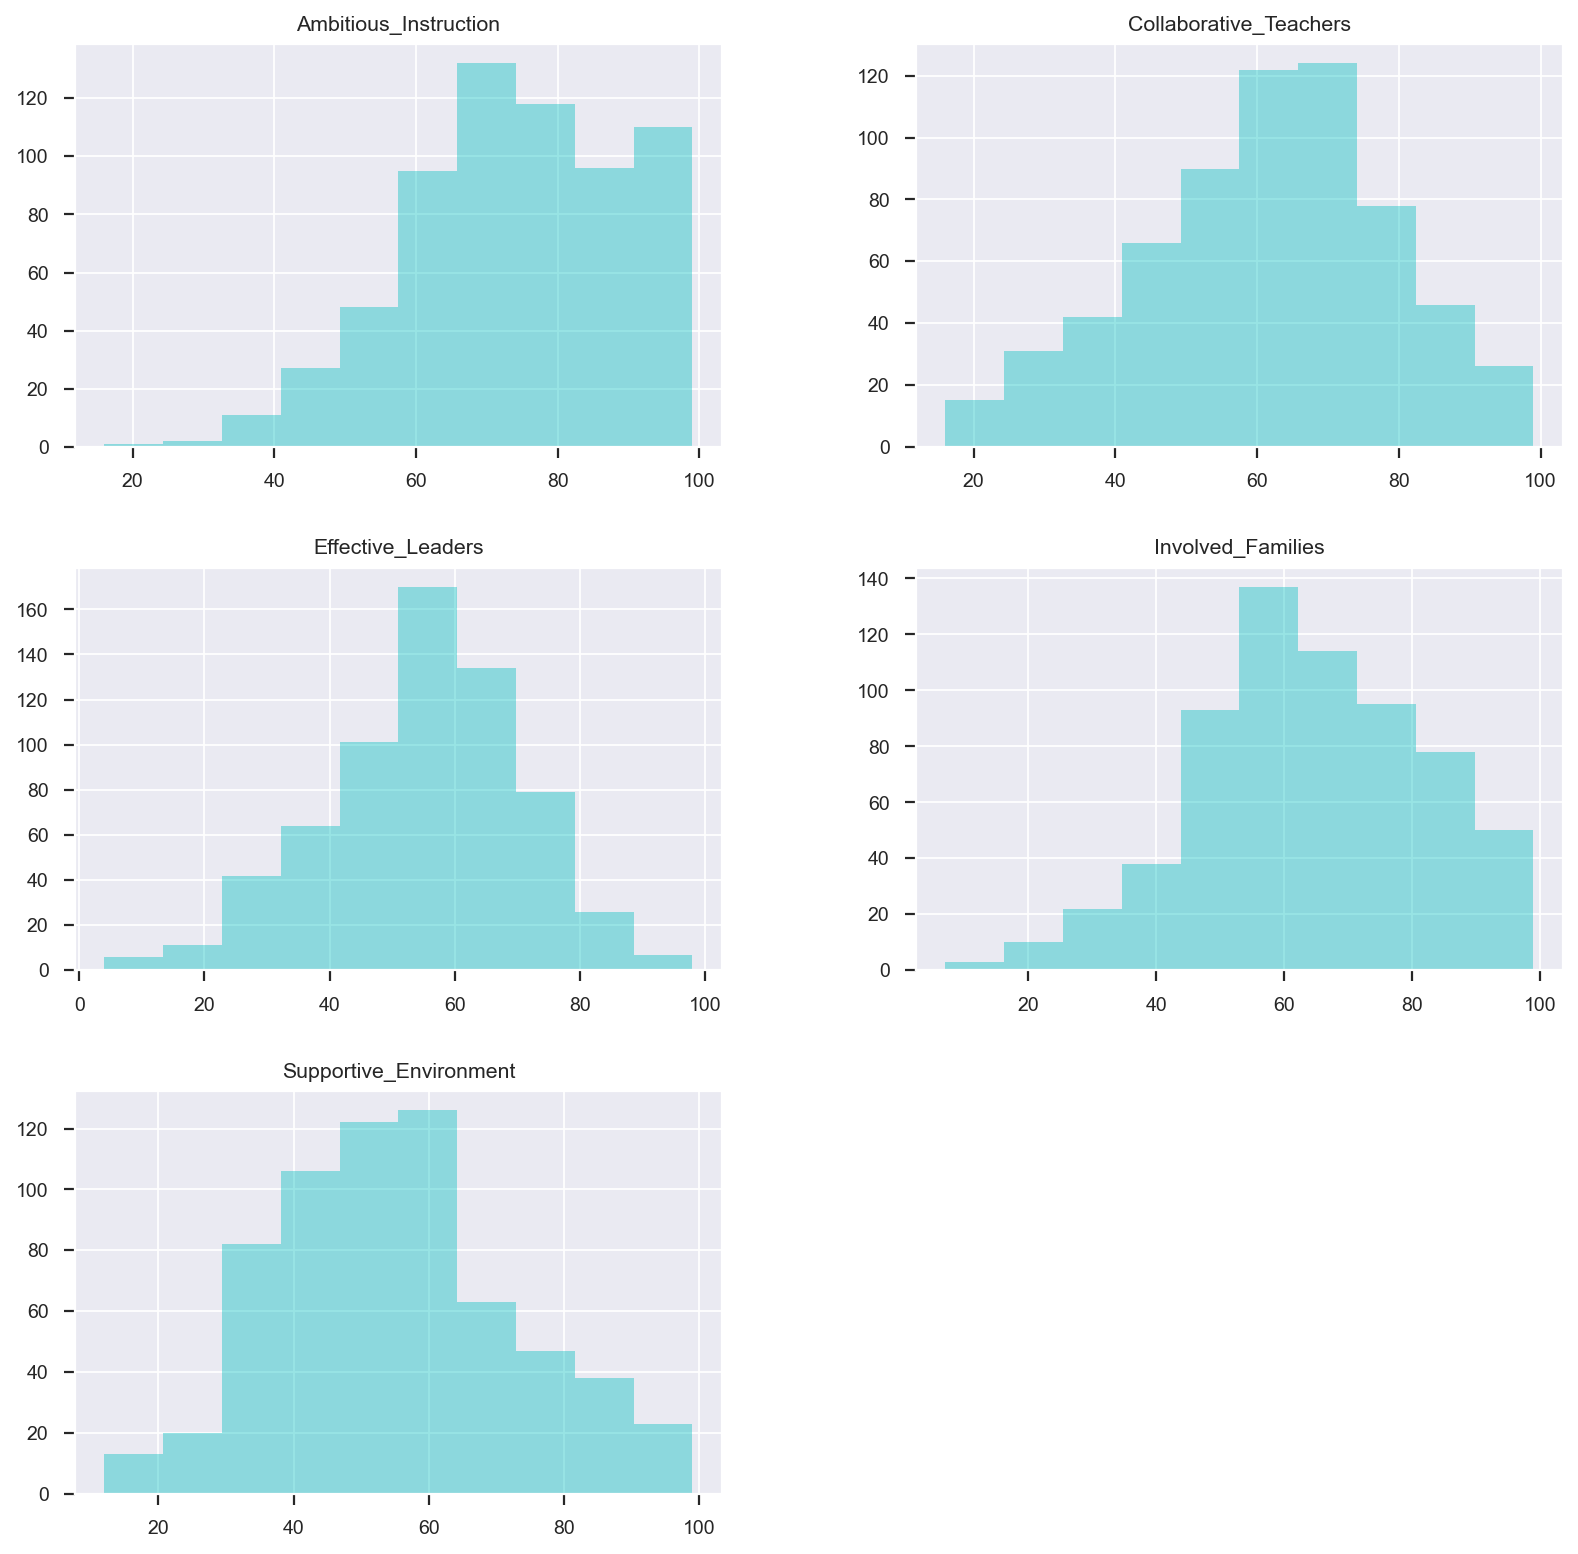

In [57]:
school_df.hist(figsize=(12,12), **viz_config);

#### Income data

In [71]:
income_data.head()

,zip,income
0,60007,75743.0
1,60018,60566.0
2,60106,67325.0
3,60131,57815.0
4,60176,53360.0


In [72]:
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   zip     68 non-null     int64  
 1   income  67 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


In [74]:
income_data.isna().sum()

zip       0
income    1
dtype: int64

In [101]:
# Find rows with income NaN
cond_isna = income_data.iloc[:, 1].isna()
income_data.loc[cond_isna]

,zip,income
44,60642,NaN


In [102]:
# Find rows with income 0
cond_zero = income_data.iloc[:, 1] == 0
income_data.loc[cond_zero]

,zip,income
54,60654,0.0
61,60666,0.0


In [116]:
# Calculate median for the income column
income_median = income_data.iloc[:,1].median()

# Assign income_median to the locations where conditions return True
income_data.iloc[(cond_isna | cond_zero).values, 1] = income_median

In [123]:
income_data.iloc[:,1].describe()

count        68.000000
mean      56778.794118
std       23573.079579
min       18464.000000
25%       42493.250000
50%       54344.000000
75%       63822.500000
max      171463.000000
Name: income, dtype: float64

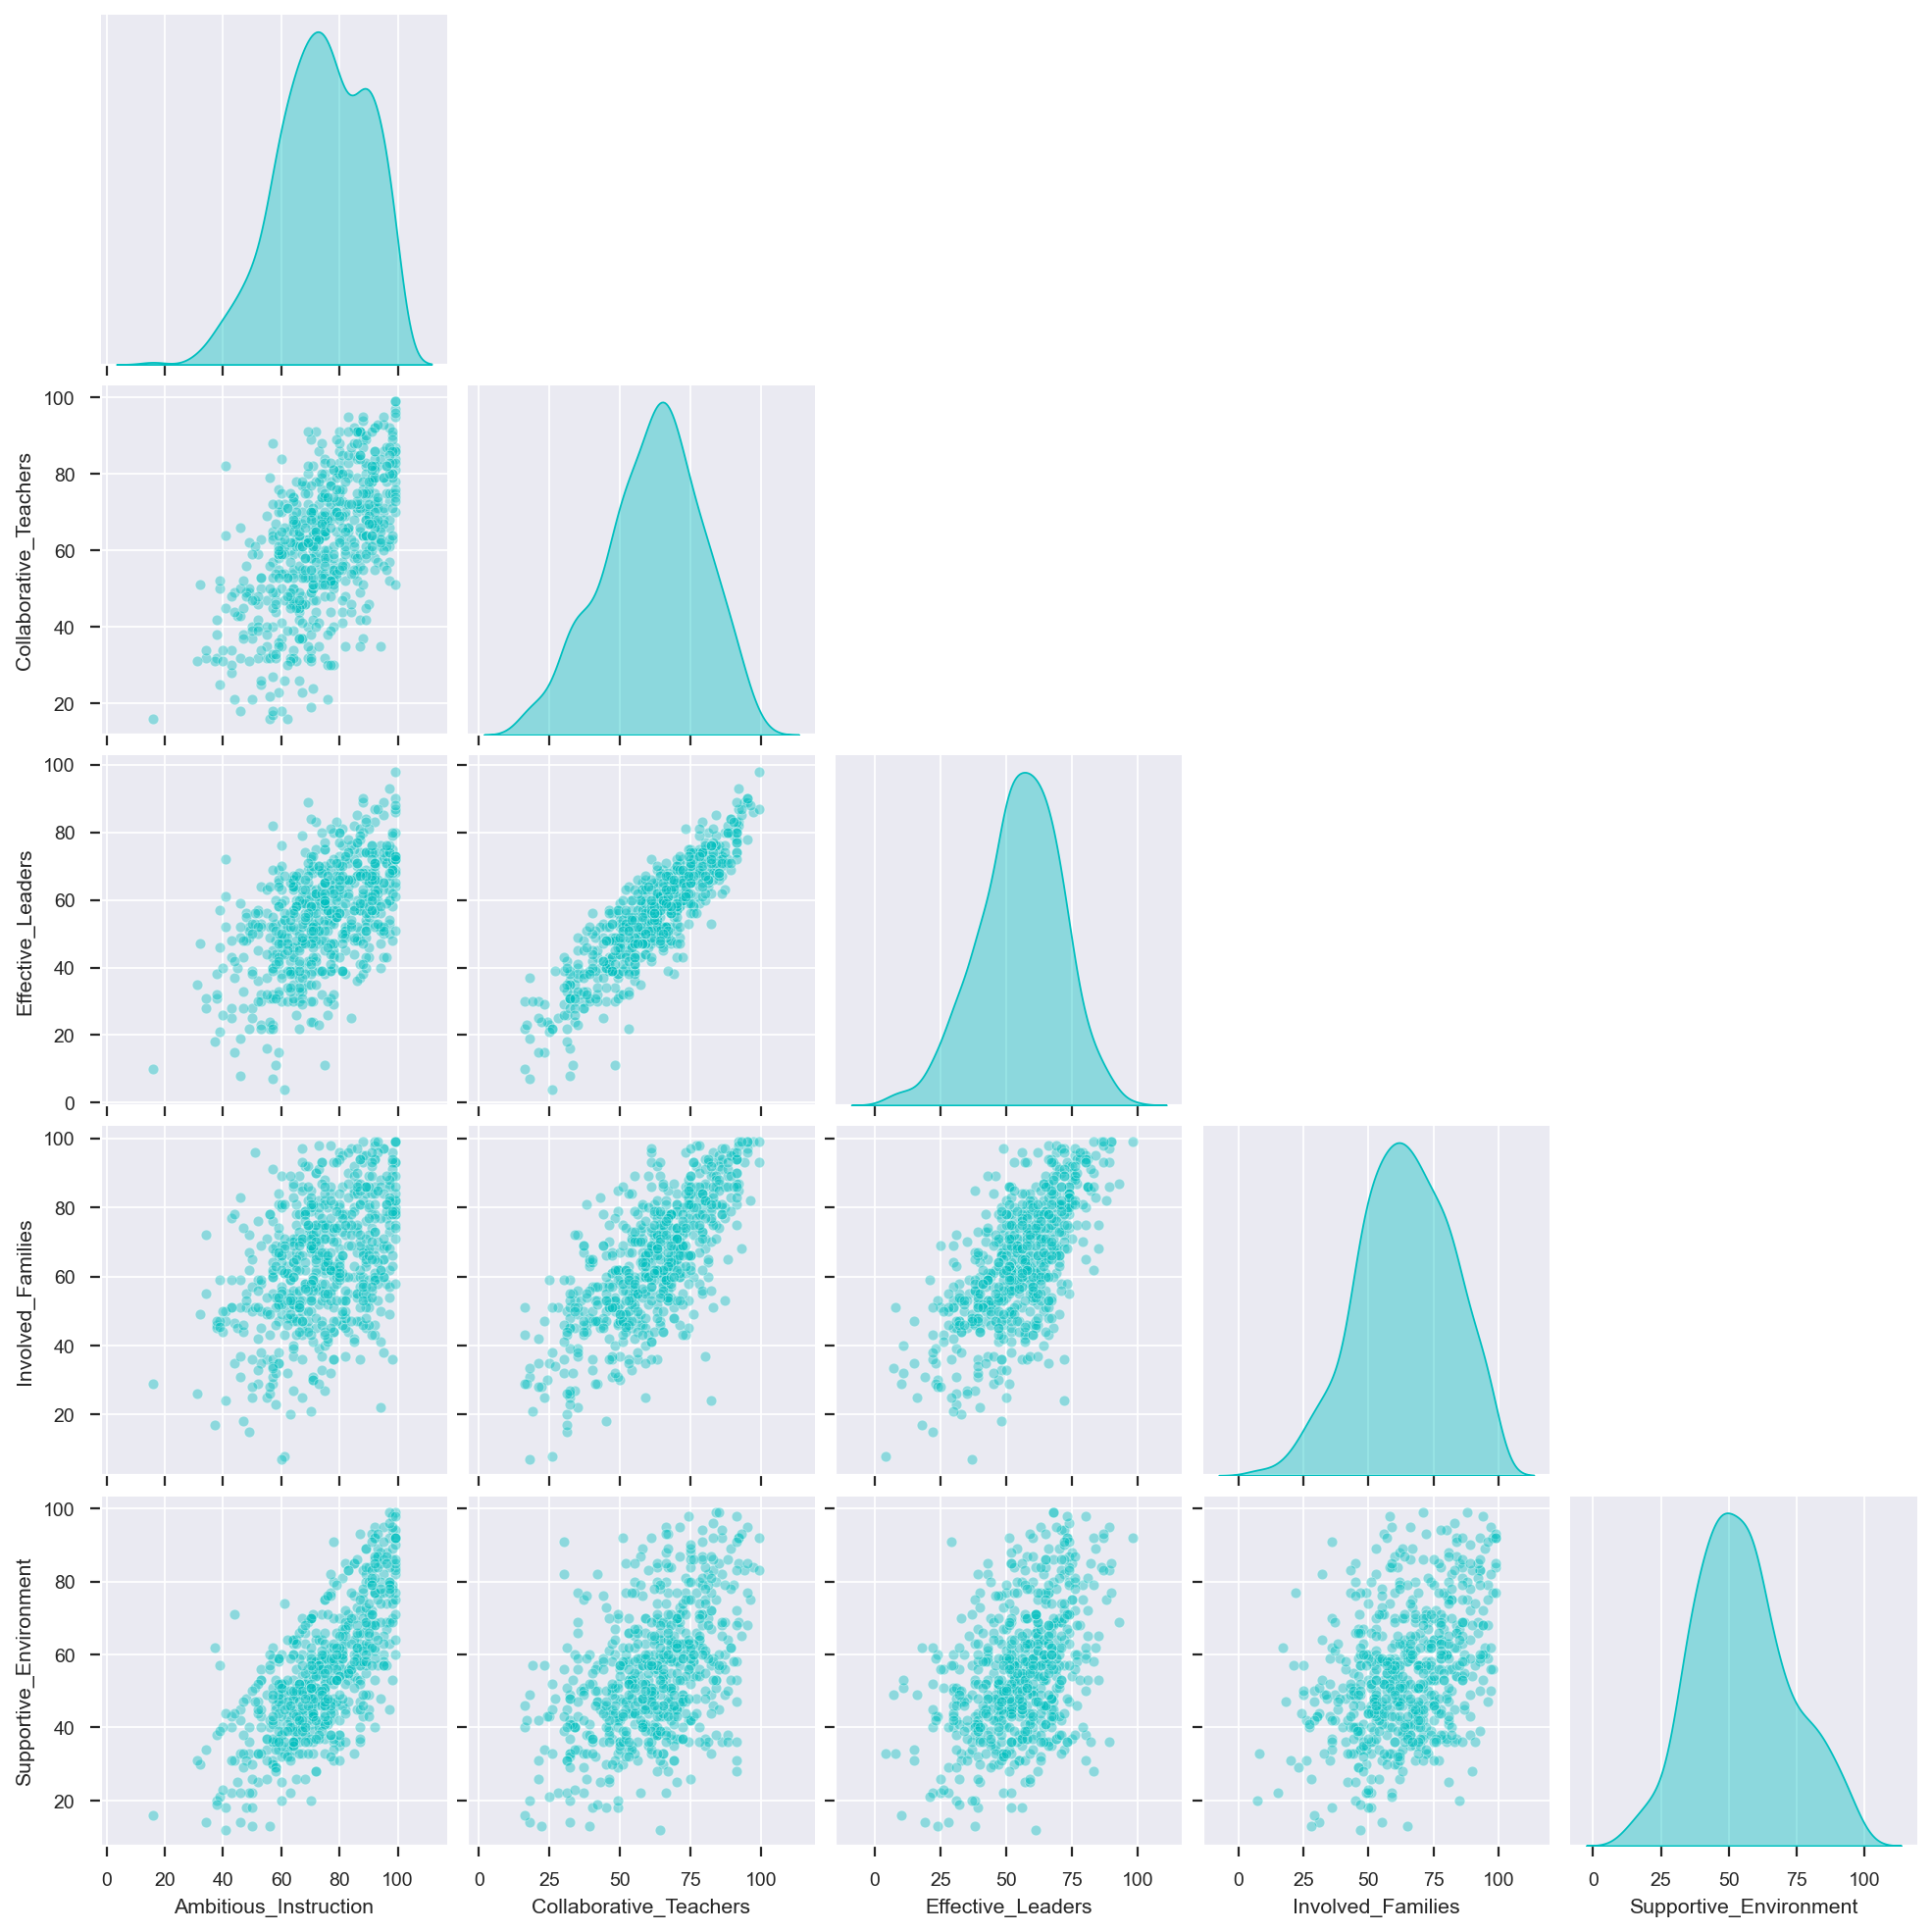

In [16]:
sns.pairplot(school_df,
             diag_kind='kde',
             corner=True, 
             plot_kws=viz_config,
             diag_kws=viz_config);

In [17]:
columns = list(school_df.columns)

In [18]:
X = school_df.values

### K-Means

In [19]:
k=5
kmeans = KMeans(n_clusters=k, random_state=random_state)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

In [20]:
kmeans.cluster_centers_

array([[86.4496124 , 60.34108527, 54.1627907 , 57.75193798, 67.90697674],
       [55.3375    , 32.1       , 29.625     , 40.16875   , 38.275     ],
       [73.03448276, 71.62758621, 63.95862069, 75.90344828, 50.25517241],
       [91.40740741, 82.86111111, 73.62037037, 84.87962963, 76.53703704],
       [64.08988764, 53.73033708, 48.87078652, 56.86797753, 43.6011236 ]])

In [21]:
# Clusters assigned to first 20 instances
kmeans.labels_[:20]

array([4, 2, 1, 2, 3, 2, 3, 4, 4, 4, 3, 1, 4, 4, 4, 1, 1, 2, 1, 4],
      dtype=int32)

In [22]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=random_state).fit(X) for k in range(2,11)]

In [23]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k]
silhouette_scores

[0.33929876671480197,
 0.27207523057233124,
 0.26515413094938756,
 0.2331478733617504,
 0.21774682978367635,
 0.2084775734136636,
 0.2034260499824815,
 0.19944646133910454,
 0.20244295002941876]

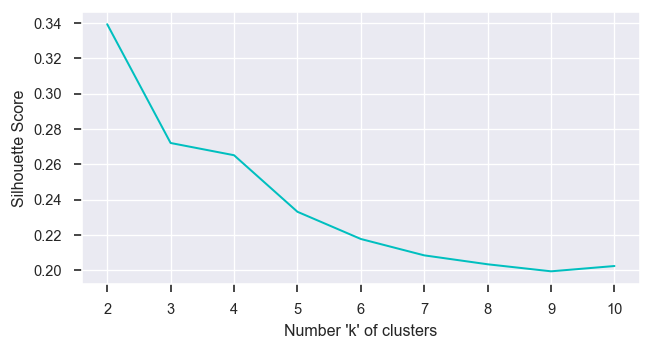

In [24]:
plt.figure(figsize=(6,3), dpi=120)
plt.plot(range(2,11), silhouette_scores, color='c')
plt.xlabel('Number \'k\' of clusters')
plt.ylabel('Silhouette Score');

For n_clusters = 2 The average silhouette_score is : 0.33929876671480197
For n_clusters = 3 The average silhouette_score is : 0.27207523057233124
For n_clusters = 4 The average silhouette_score is : 0.2649064457622722
For n_clusters = 5 The average silhouette_score is : 0.232351708804528
For n_clusters = 6 The average silhouette_score is : 0.2210408145671489
For n_clusters = 7 The average silhouette_score is : 0.20821737099886936
For n_clusters = 8 The average silhouette_score is : 0.20215391242455455
For n_clusters = 9 The average silhouette_score is : 0.19944545629412097
For n_clusters = 10 The average silhouette_score is : 0.20809742885597124


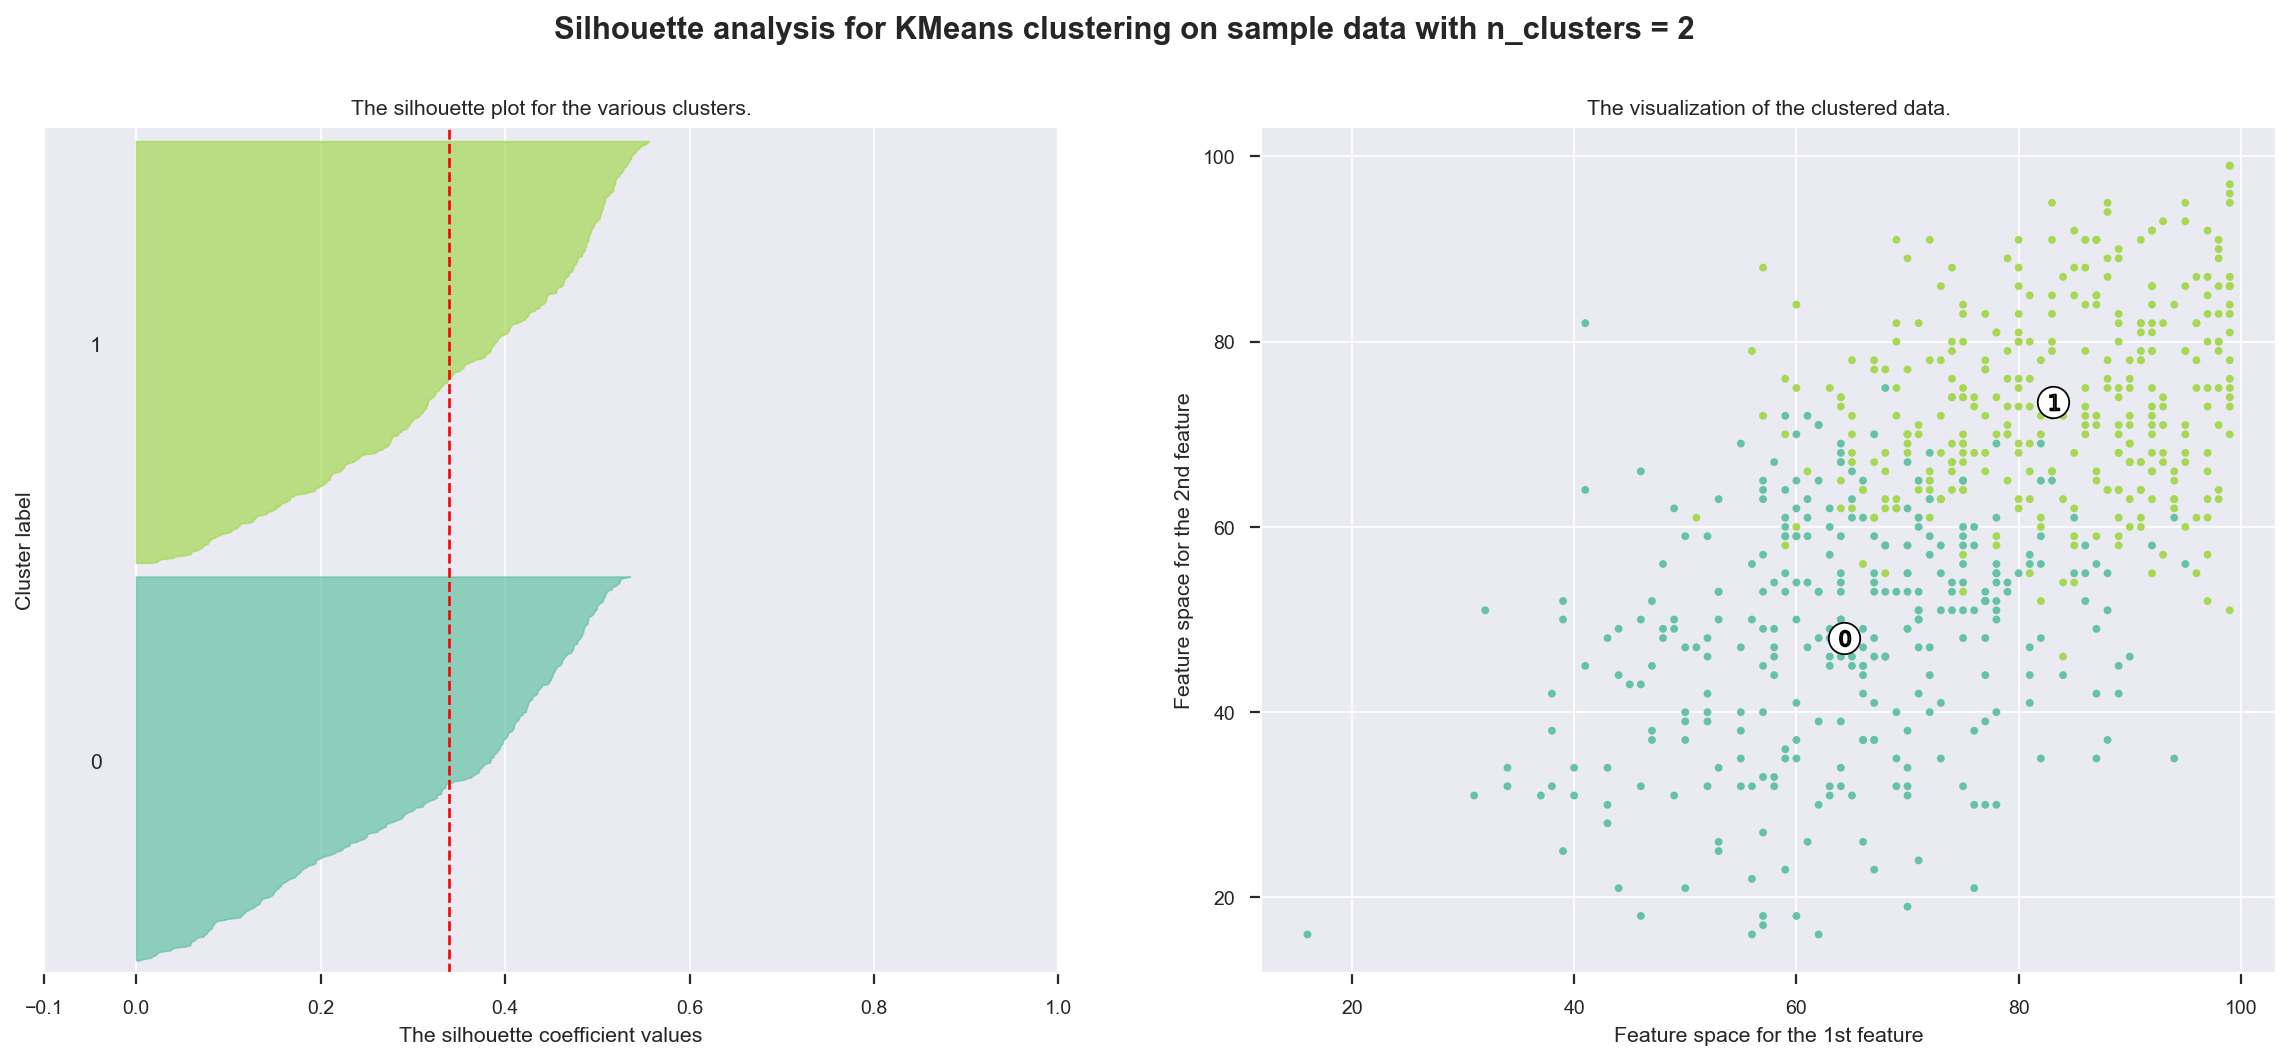

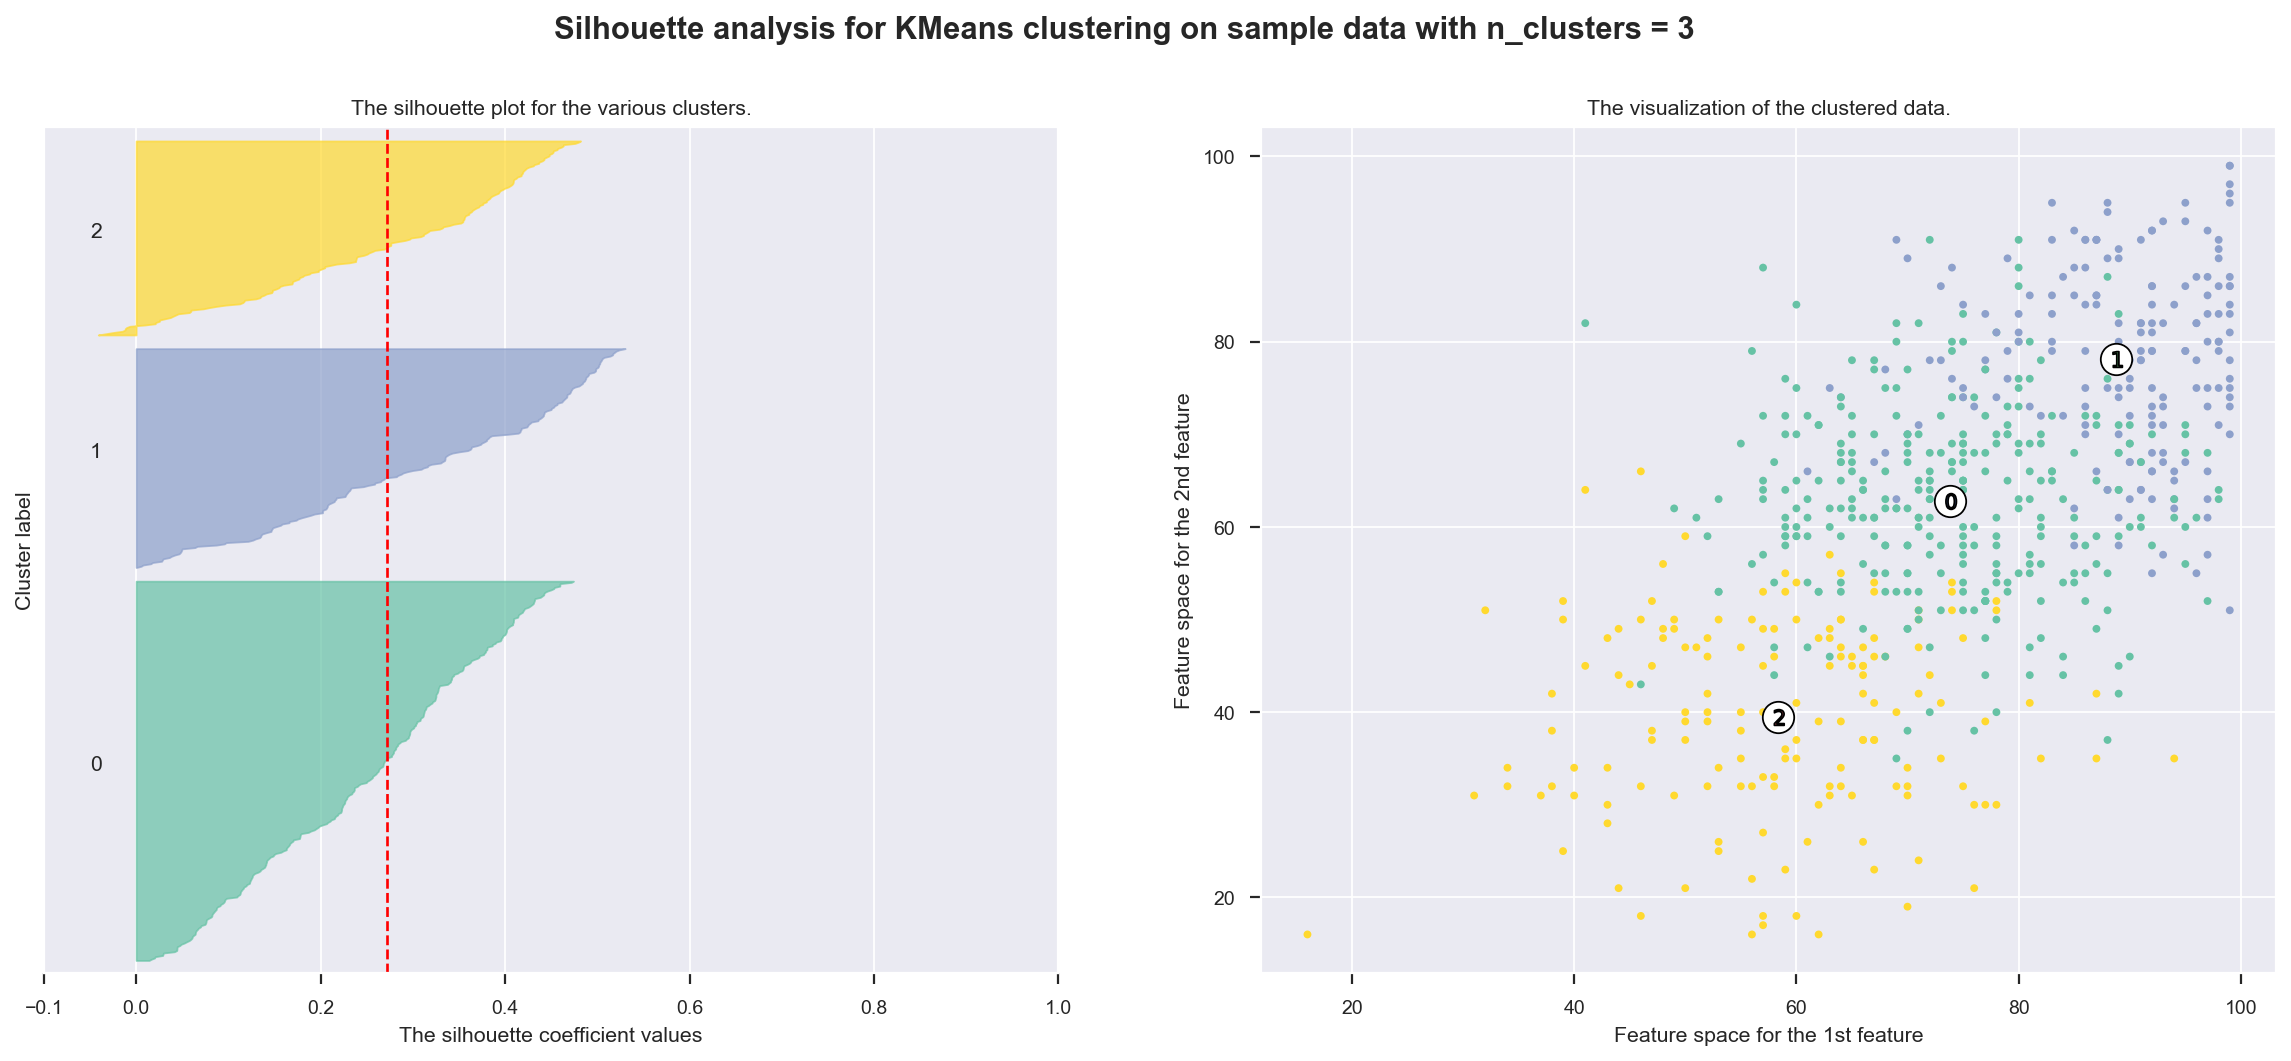

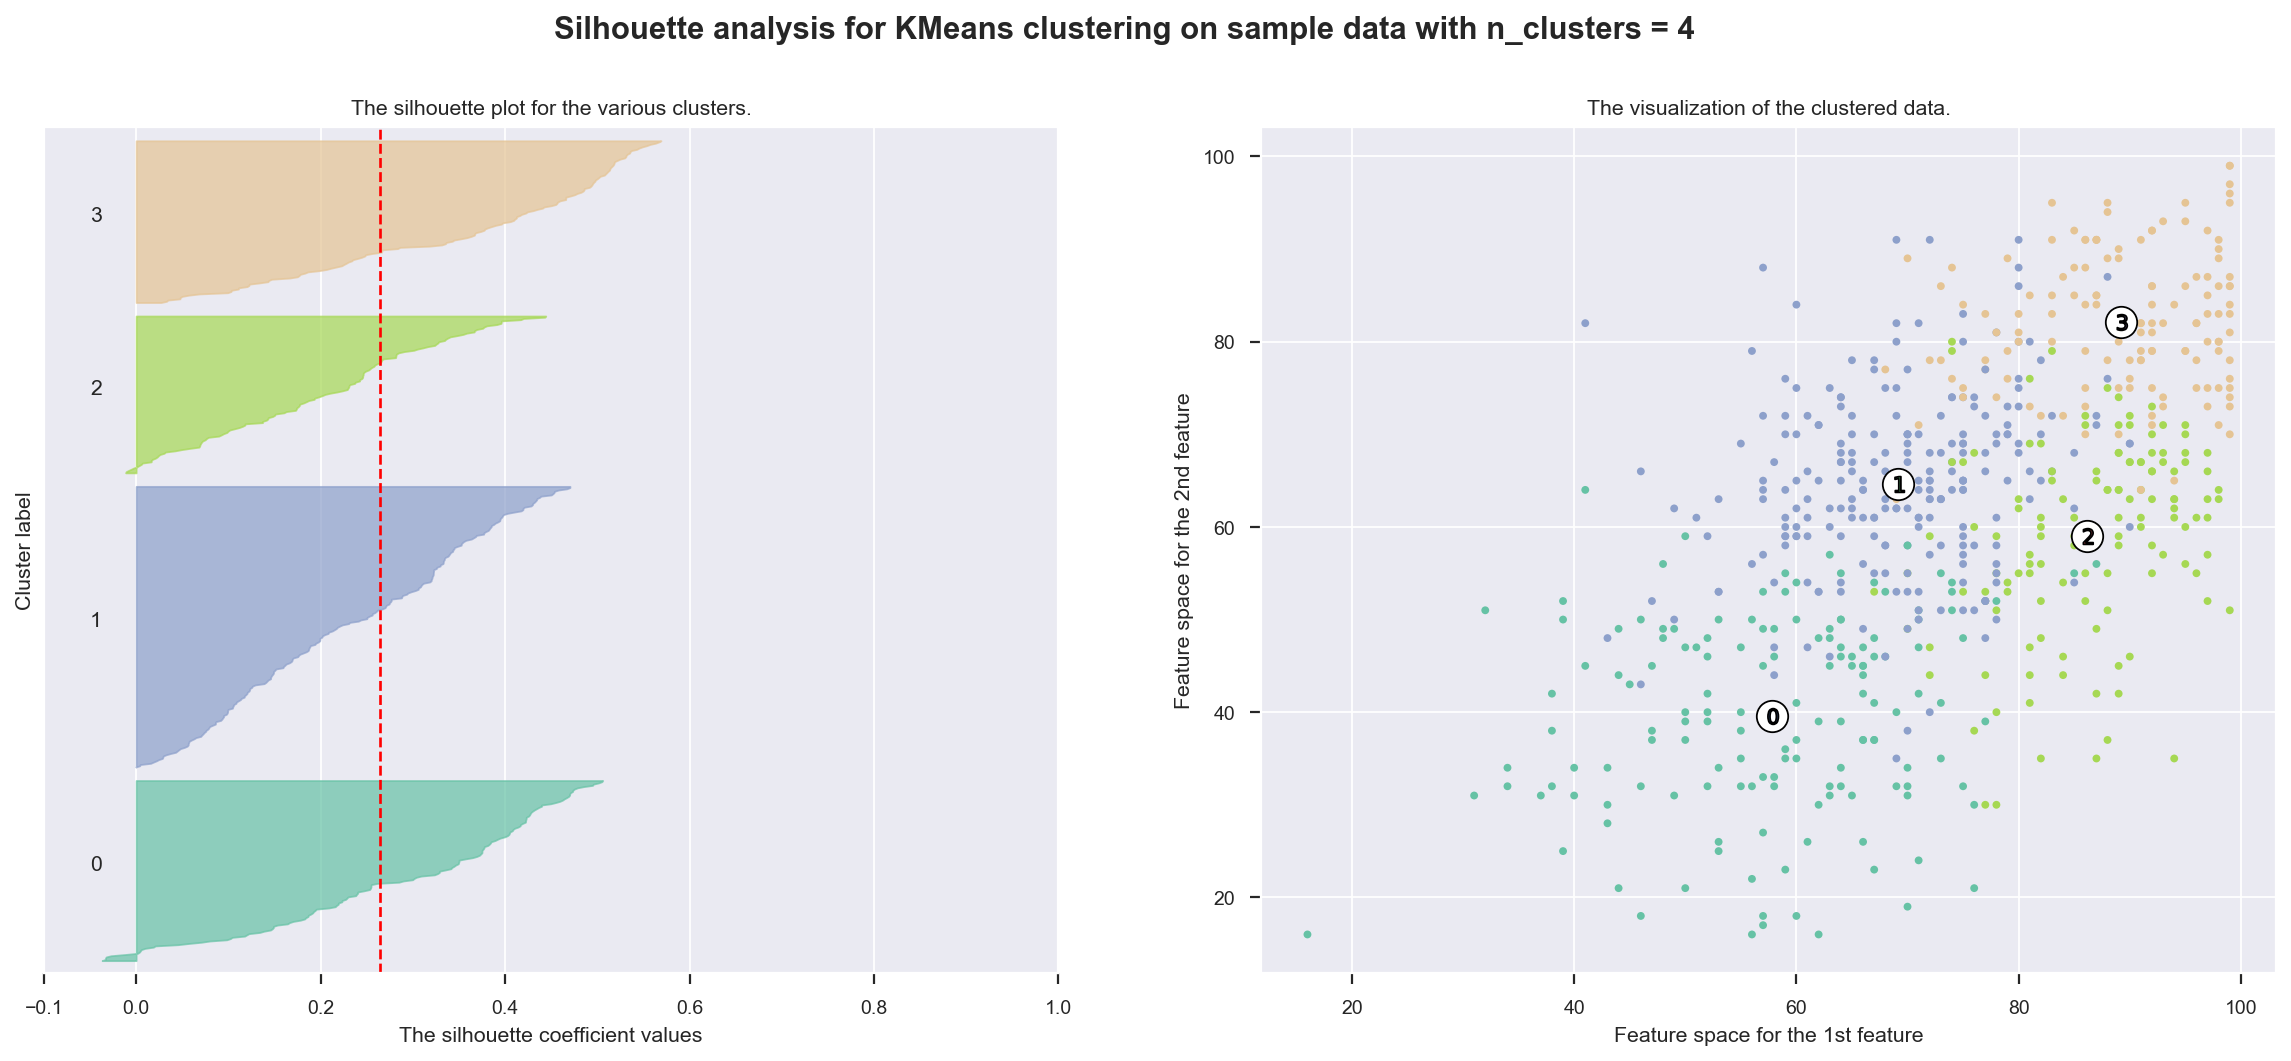

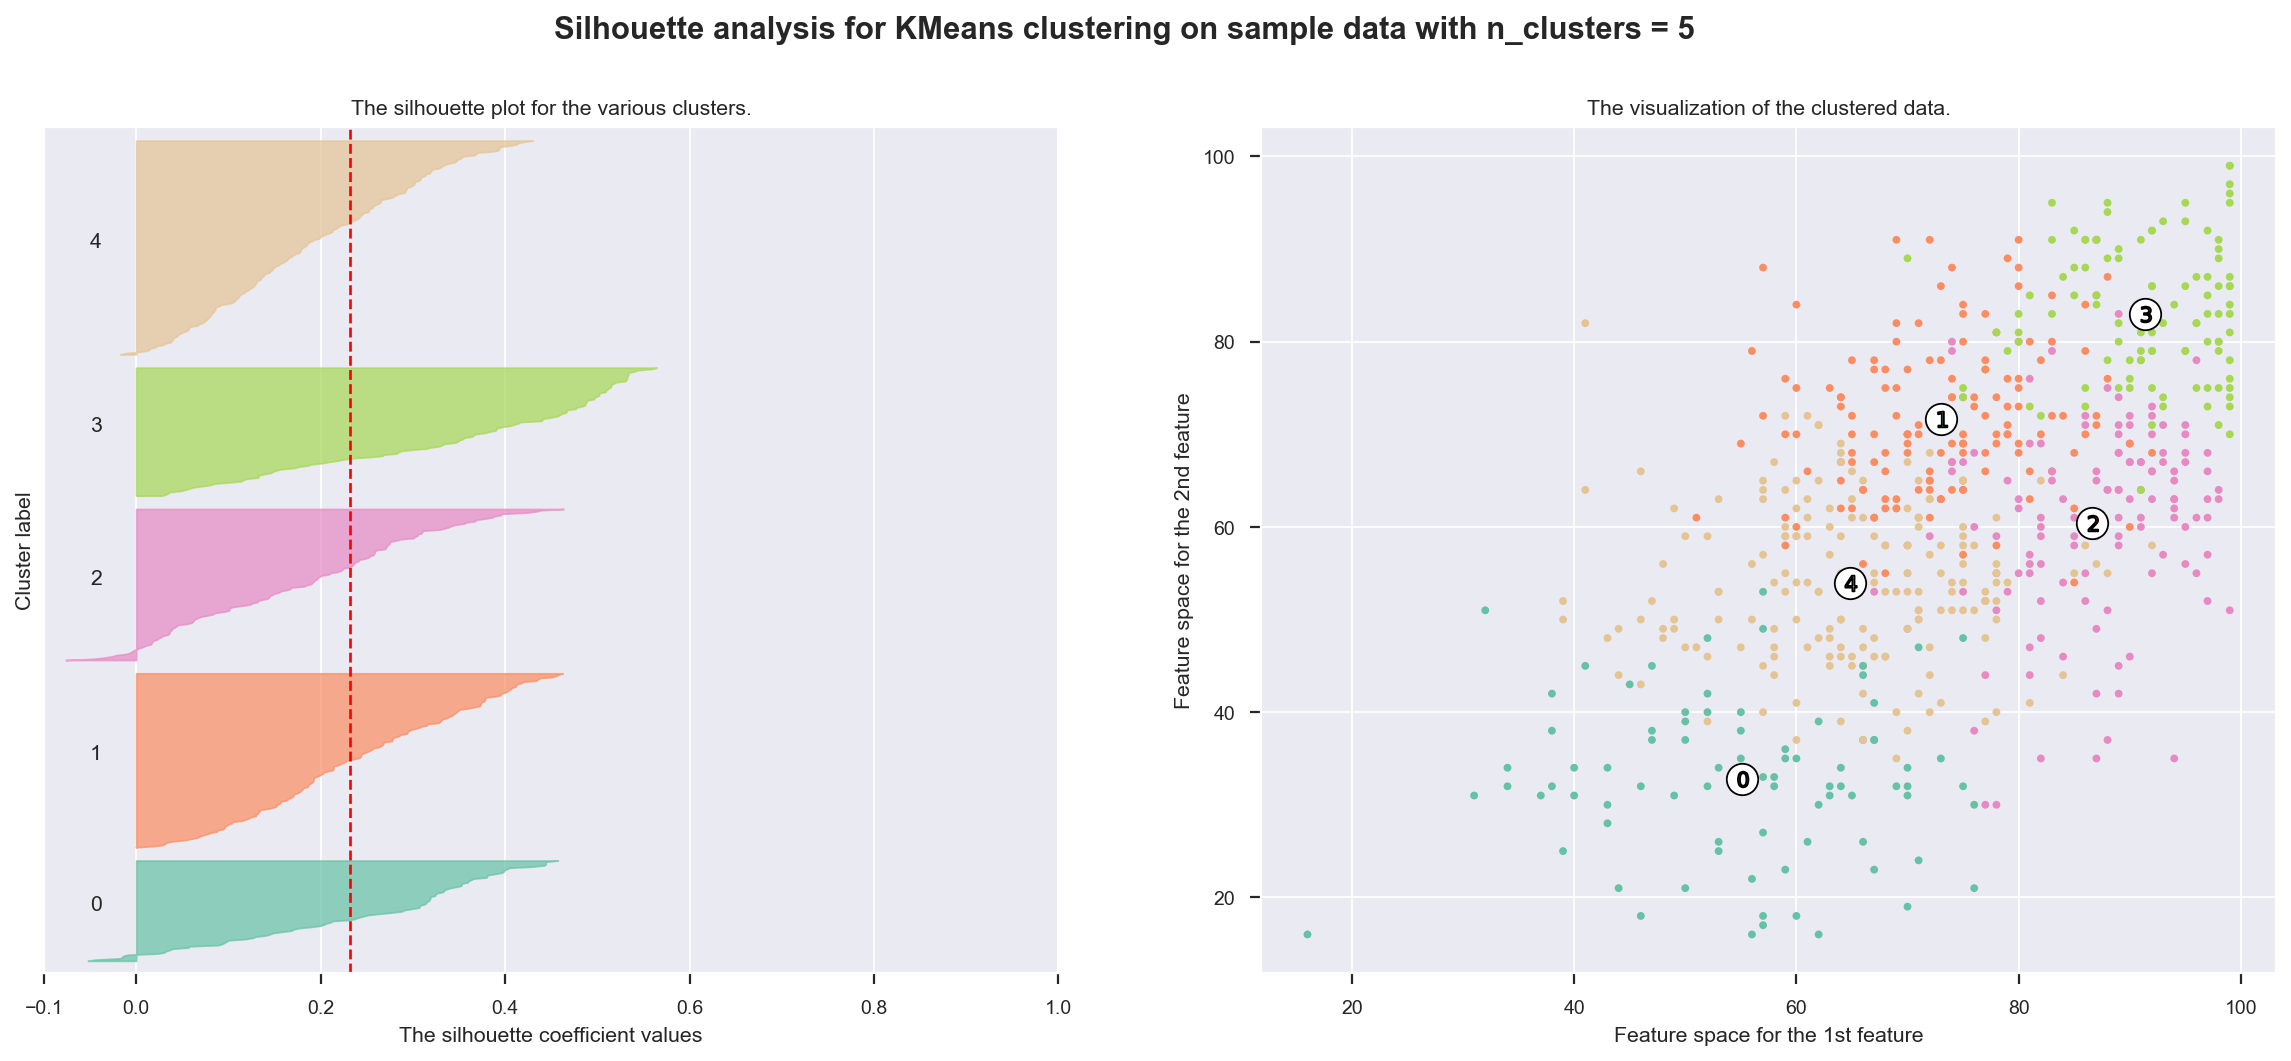

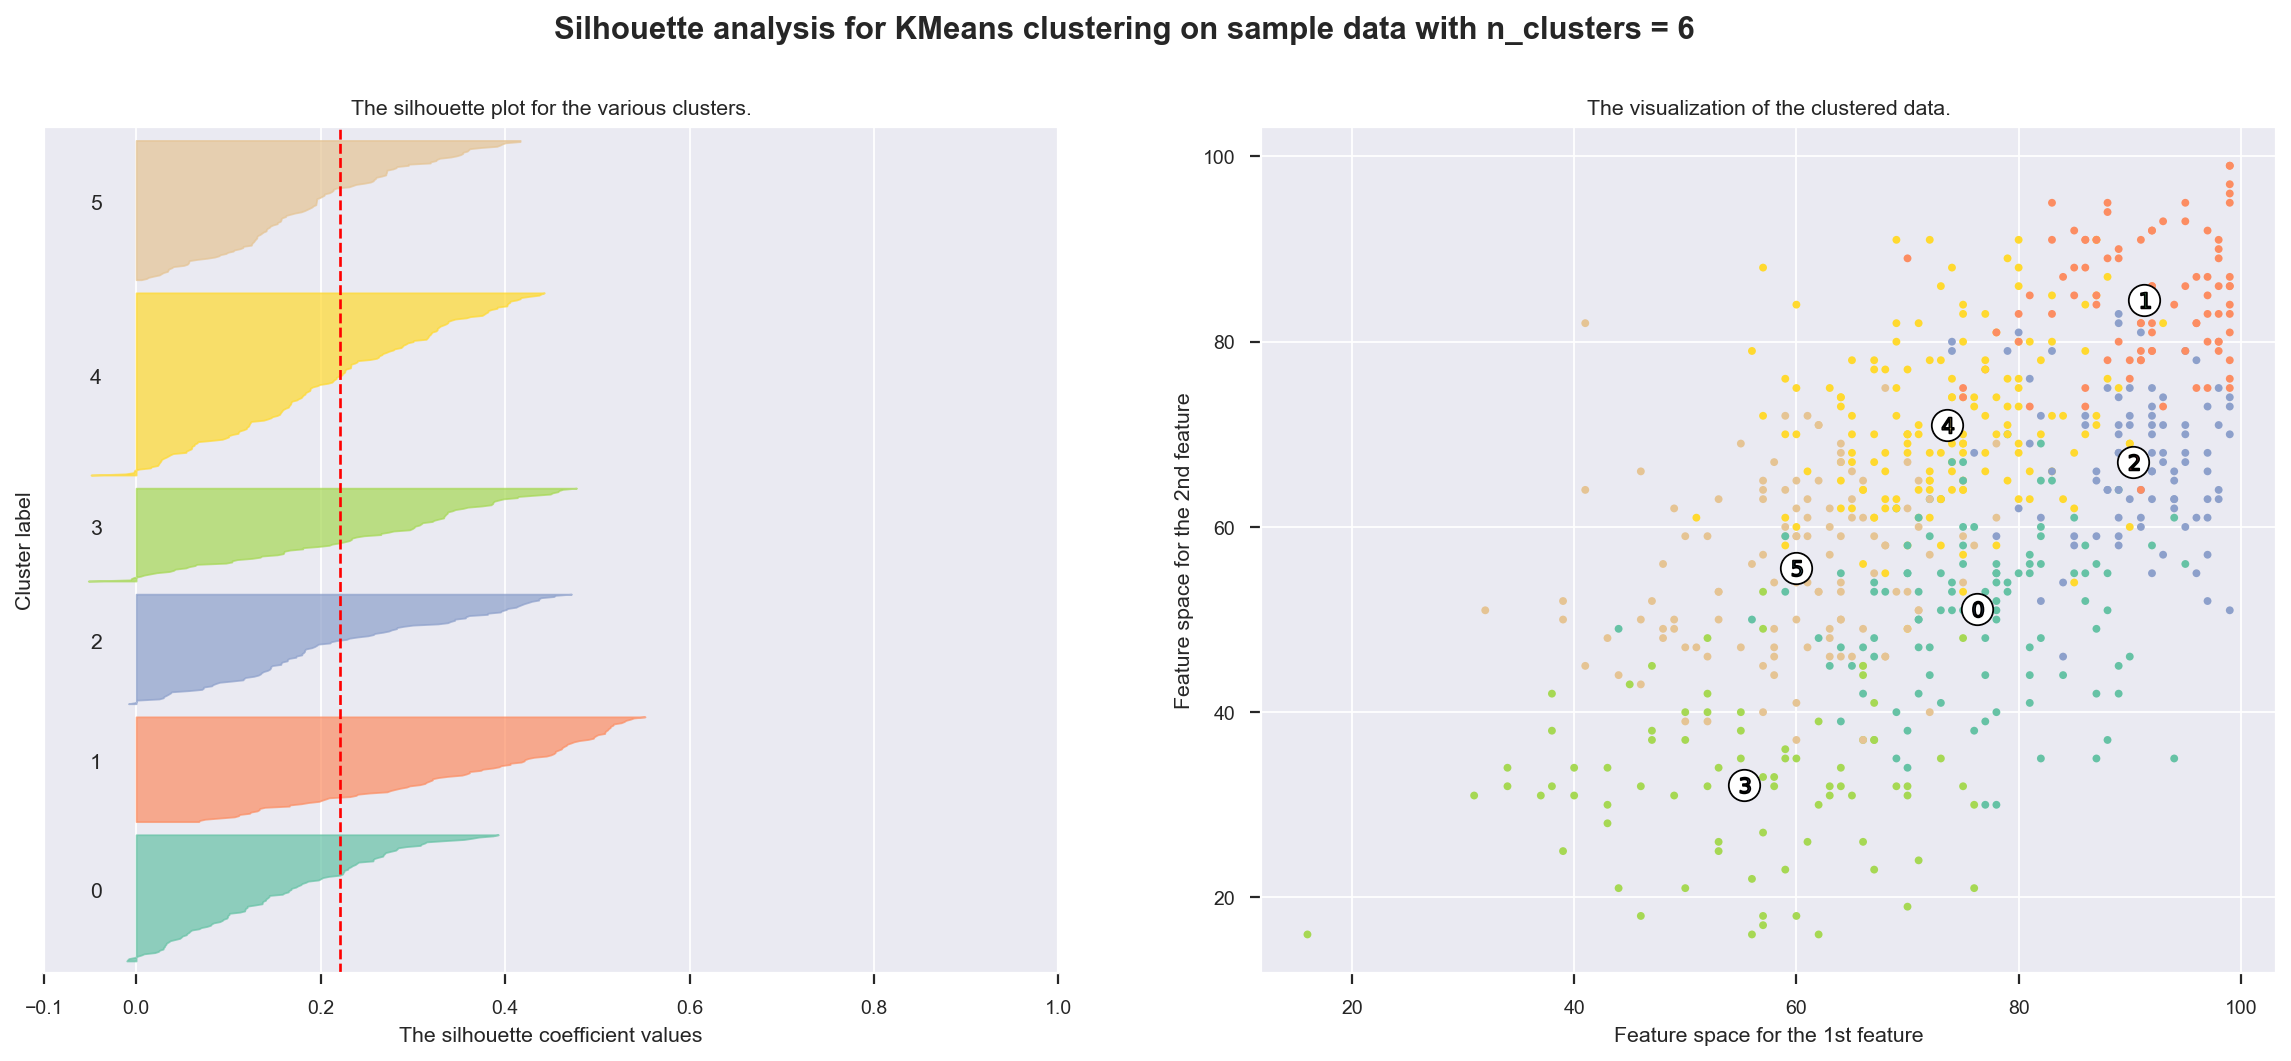

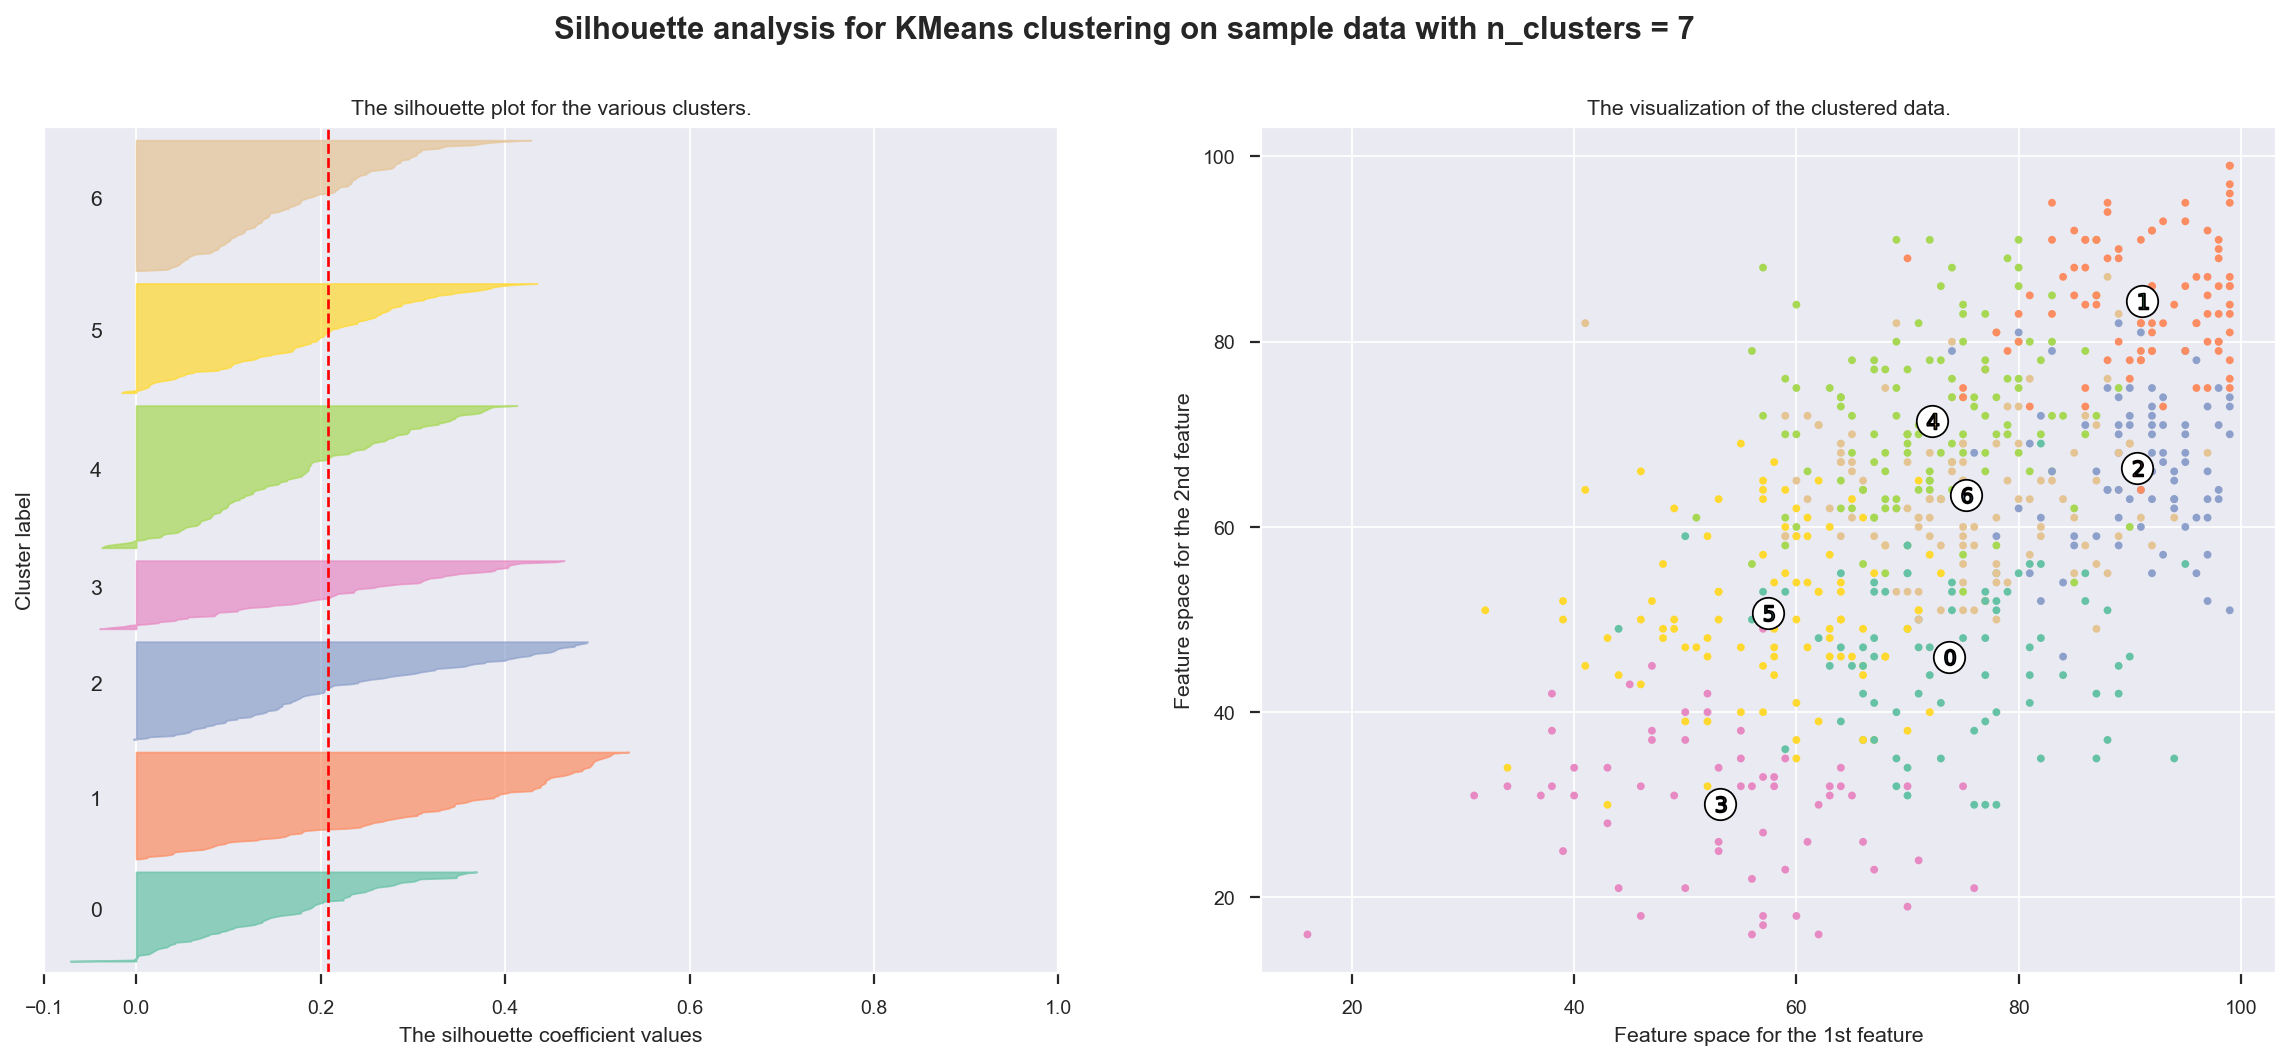

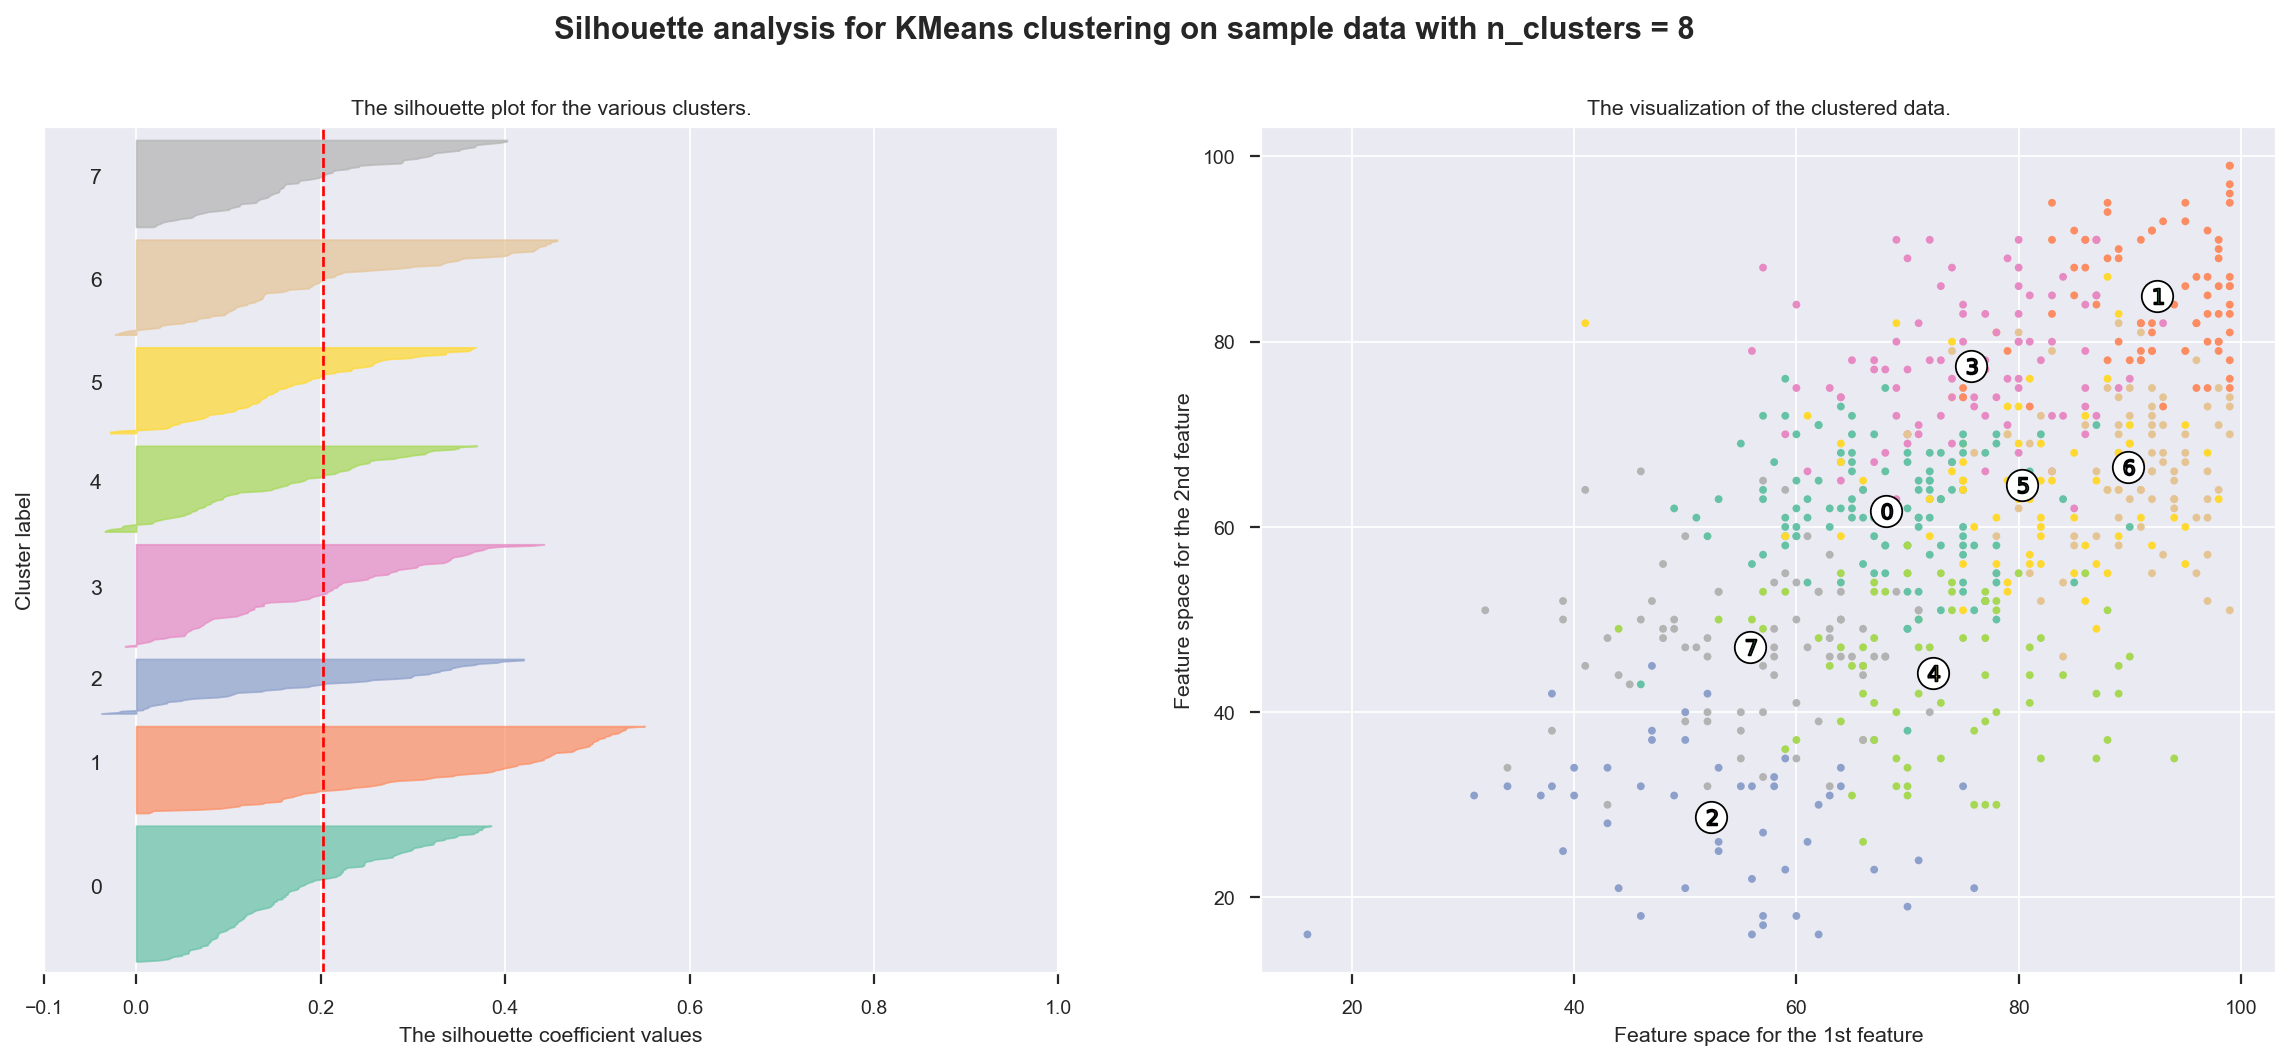

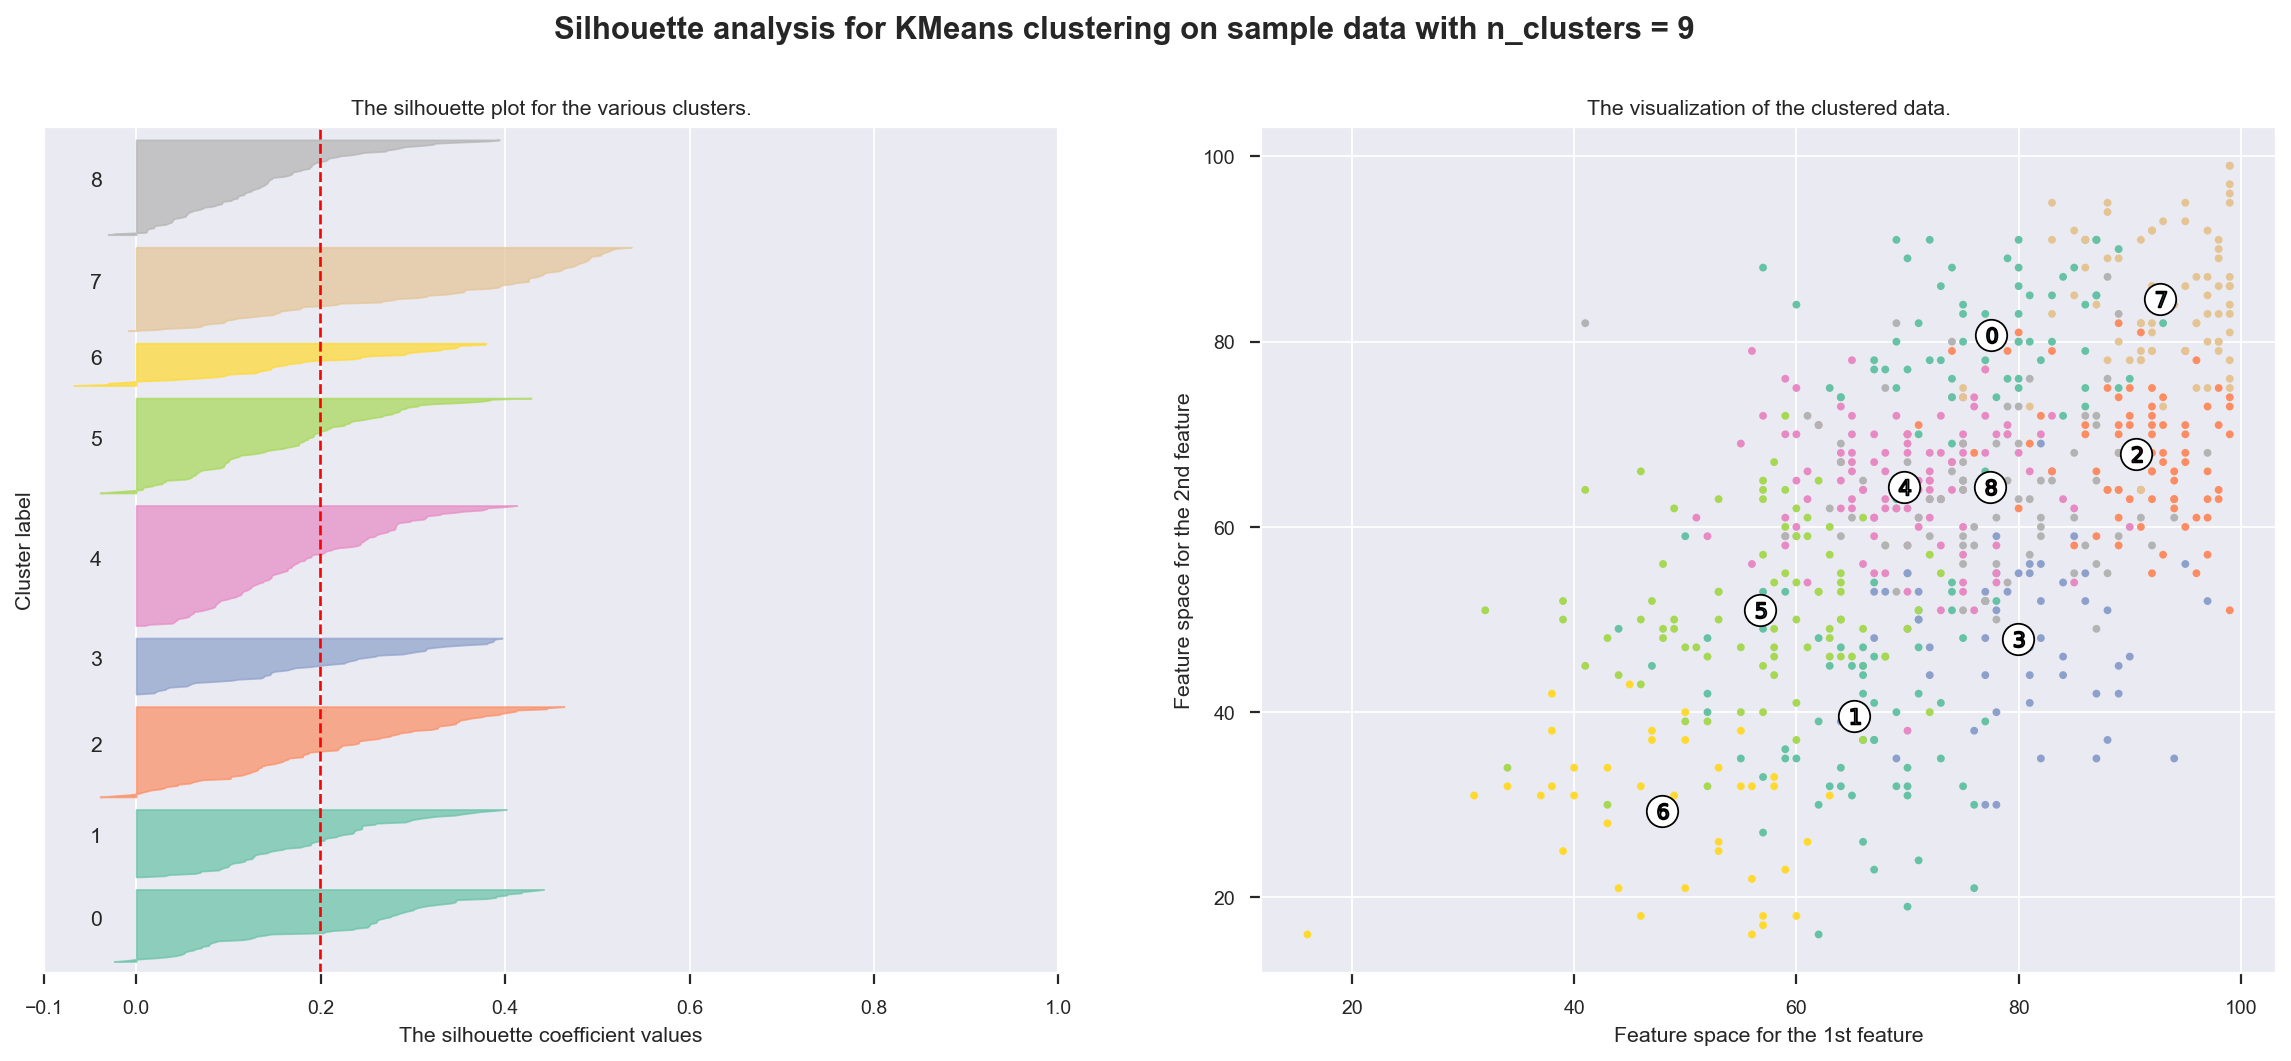

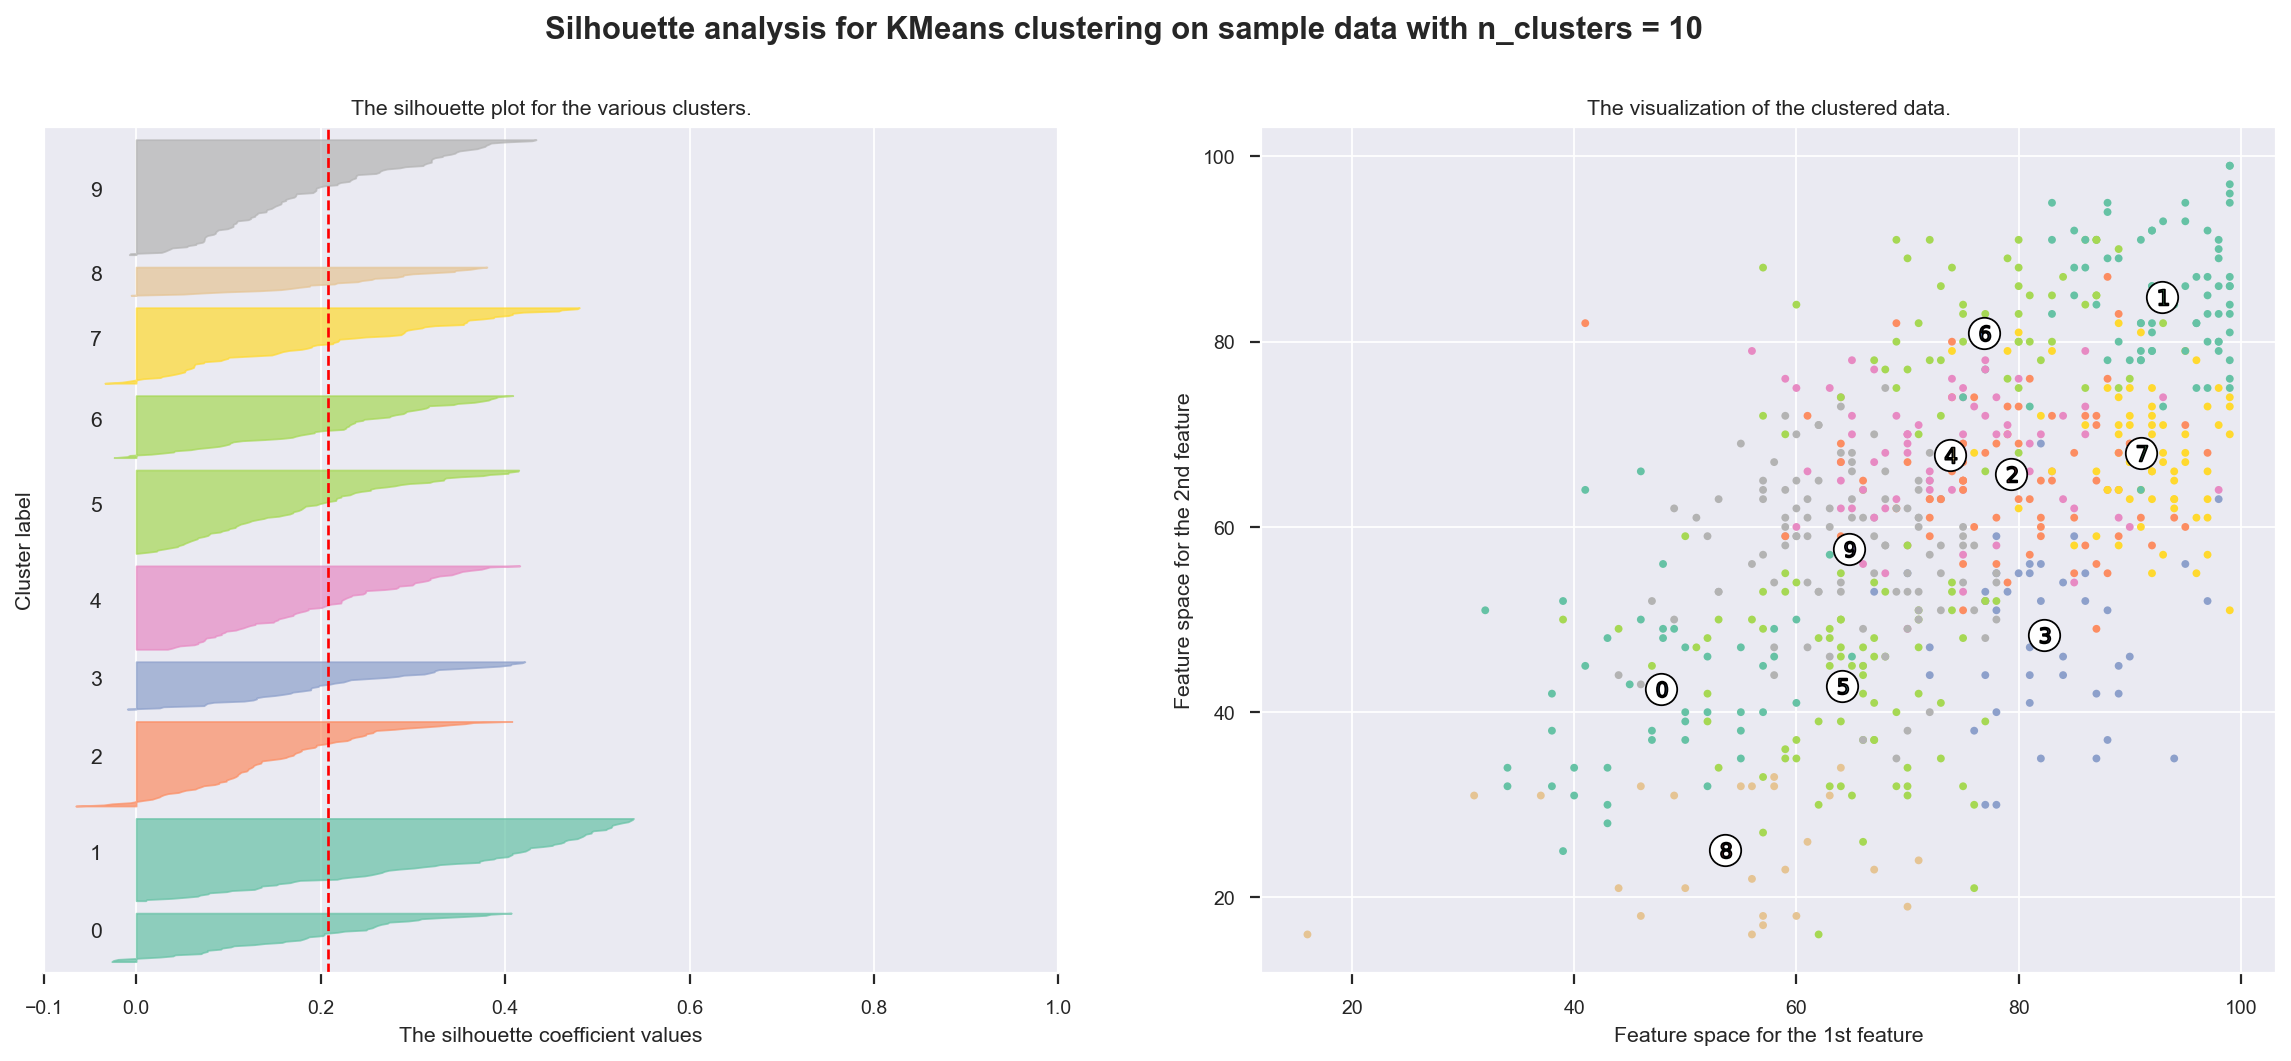

In [25]:
### COPIED FROM https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html###

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = range(2,11)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Set2(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.Set2(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=50, lw=0, alpha=1,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show();

### DBSCAN

A big challenge when using DBSCAN is tuning the hyperparameters (epsilon and min_samples).

In [26]:
### Reference: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc#
# Get distance to nearest neighbor for each instance. n_neighbors includes the instance itself.
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# 0th column is all 0s: distance between each instance and itself
# 1st column is distance between each distance and its closest neighbor
# Here is a (sorted) list of those distances for 20 instances
distances = np.sort(distances[:,1], axis=0)
distances[:20]

array([2.        , 2.        , 2.        , 2.        , 3.16227766,
       3.16227766, 3.16227766, 3.16227766, 3.31662479, 3.31662479,
       3.31662479, 3.31662479, 3.46410162, 3.46410162, 3.74165739,
       3.74165739, 3.87298335, 3.87298335, 3.87298335, 3.87298335])

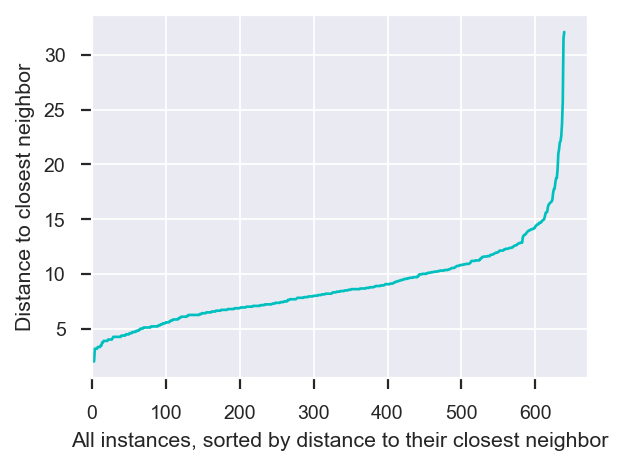

In [27]:
plt.figure(figsize=(4,3))
plt.plot(distances, color='c')
plt.xlim(0)
plt.xlabel('All instances, sorted by distance to their closest neighbor')
plt.ylabel('Distance to closest neighbor')
plt.show();

Ideal epsilon to cluster as many instances as possible while discarding outliers is between 12 and 17. I will choose 15 for now.

In [41]:
### Reference: https://medium.com/@mohantysandip/a-step-by-step-approach-to-solve-dbscan-algorithms-by-tuning-its-hyper-parameters-93e693a91289
dbscan = DBSCAN(eps=17, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=17)

In [42]:
pd.Series(dbscan.labels_).value_counts()

 0    616
-1     24
dtype: int64

### Explore the outliers

In [30]:
outliers_df = school_df[dbscan.labels_ == -1]
outliers_df

,Ambitious_Instruction,Collaborative_Teachers,Effective_Leaders,Involved_Families,Supportive_Environment
Avalon Park Elementary School,94.0,35.0,40.0,22.0,77.0
Bridgescape Academy Humboldt Park,44.0,49.0,37.0,46.5,71.0
CICS - Longwood,41.0,64.0,61.0,47.0,12.0
Carrie Jacobs Bond Elementary School,78.0,30.0,29.0,36.0,91.0
Douglas Taylor Elementary School,46.0,32.0,8.0,51.0,33.0
Evergreen Academy Middle School,97.0,92.0,93.0,87.0,69.0
George Leland Elementary School,72.0,91.0,83.0,90.0,28.0
George Washington Carver Primary School,61.0,26.0,4.0,8.0,33.0
Inter-American Elementary Magnet School,70.0,49.0,38.0,85.0,20.0
John W Cook Elementary School,75.0,48.0,11.0,40.0,51.0
